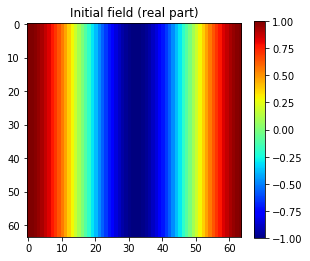

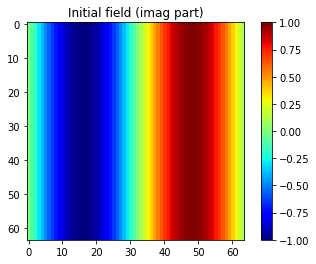

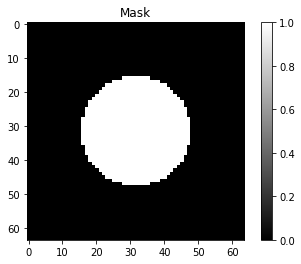

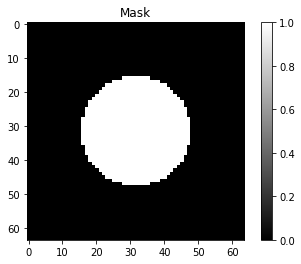

In [258]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import copy


def empty_mask(size):
    return np.zeros((size,size))

def circular_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[(x-x0)**2+(y-y0)**2<=r**2]=1
    return M

def rectangle_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[((x-x0)**2<=r**2)*((y-y0)**2<=r**2)]=1
    return M
    

    
def get_plane_wave(E0,k,size):
    y,x = np.mgrid[:size, :size]
    a = np.pi*0/180
    E = E0*np.exp(-1j*k*(x*np.cos(a)+y*np.sin(a)))
    return(E) 
    
def get_greenfun(r,k):
    return (1j/4)*scipy.special.hankel1(0,k*r)

def get_green_matrix(k,size):
    j,i = np.mgrid[:size, :size]
    ij_block = np.sqrt((i-1/2)**2+j**2)
    green_mat = get_greenfun(ij_block,k)
    return green_mat

# def get_toeplitz_mat(ij_block):
#     ij_block = copy.deepcopy(ij_block)
#     T = np.block([[ij_block,ij_block[:,:0:-1]],
#                   [ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]]])
#     return T

def get_toeplitz_mat(ij_block):
    ij_block = copy.deepcopy(ij_block)
    T1 = np.hstack((ij_block,ij_block[:,:0:-1]))
    T2 = np.hstack((ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]))
    T = np.vstack((T1,T2))
    return T
    
def G_matvec(vec,k):
    size = int(np.sqrt(vec.shape[0]))
    G_block = get_green_matrix(k,size)
    G = get_toeplitz_mat(G_block)
    mat = np.zeros((2*size-1,2*size-1),dtype = np.complex64)
    mat_block = vec.reshape((-1,size))
    mat[:size,:size] = mat_block
    out_mat = np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(mat))
    out = out_mat[:size,:size].reshape((-1,1))
    return out

def get_eps_from_mask(e,mask):
    return (e-1)*mask.reshape((-1,1))+1

def matvec(x,eps,k,transpose = False):
    x = x.reshape((-1,1))
    #print(x)
    size = x.shape[0]
    chi = k**2*(eps - 1)
    if transpose:
        return x-chi*G_matvec(x,k)
    else:
        return x-G_matvec(x*chi,k)

def old_matvec(x,mask,k,e):
    eps = get_eps_from_mask(e,mask)
    return matvec(x,eps,k)

def visualize(data,title = "",cmap='jet',):
    plt.title(title)
    neg = plt.imshow(data, cmap=cmap, interpolation='none')
    plt.colorbar(neg)
    plt.show()


    
def solve(E,eps0,eps1):
    return E


size = 64
e =2.25
k  = 2*np.pi/(size/1)
F = get_plane_wave(1,k,size)
#mask = empty_mask(size)
#mask = rectangle_mask(size)
mask = circular_mask(size)
eps = get_eps_from_mask(e,mask)
visualize(F.real,"Initial field (real part)")
visualize(F.imag,"Initial field (imag part)")
visualize(mask,"Mask","gray")

visualize(mask,"Mask","gray")
    



-0.27741384506225586


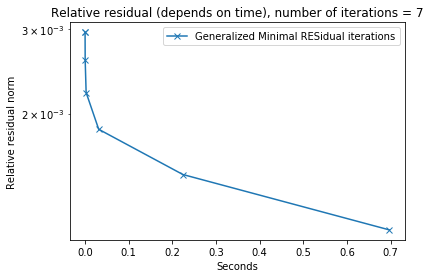

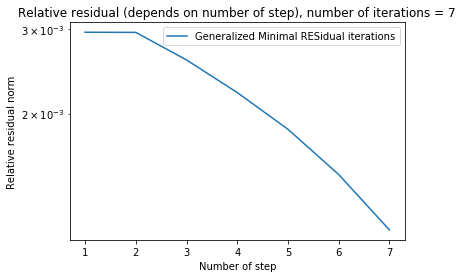

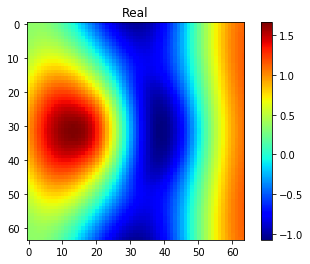

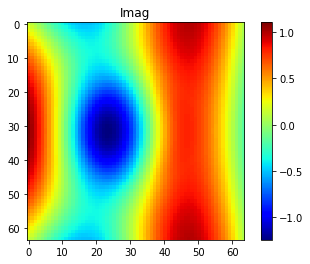

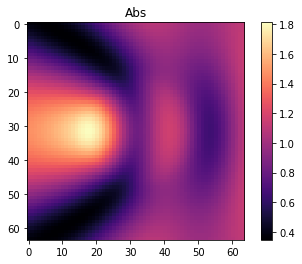

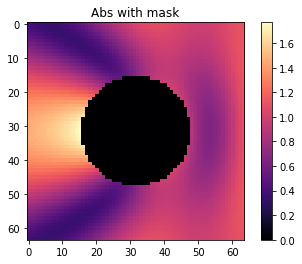

In [260]:
import scipy.sparse.linalg as spla
import inspect
import time

x_last = get_plane_wave(1,k,size).reshape(-1,1)
def plot__solution_re_im_abs_mask(solution, size):
    solution_re = solution.real.reshape(-1,size)
    solution_im = solution.imag.reshape(-1,size)
    solution_abs = np.abs(solution).reshape(-1,size)
    solution_abs_mask = np.abs(solution).reshape(-1,size)*(1-mask)
    visualize(solution_re,"Real")
    visualize(solution_im,"Imag")
    visualize(solution_abs,"Abs","magma")
    visualize(solution_abs_mask,"Abs with mask","magma")
    return solution_re, solution_im, solution_abs, solution_abs_mask

def plot_relative_residuals_norms(t, residuals, relative_vector):
    plt.semilogy(t, residuals/np.linalg.norm(relative_vector), 'x-', label="Generalized Minimal RESidual iterations")
    plt.legend()
    plt.title('Relative residual (depends on time), number of iterations = %i' % len(residuals))
    plt.xlabel('Seconds')
    plt.ylabel('Relative residual norm')
    plt.show()
    plt.semilogy(np.arange(len(residuals), 0, -1), residuals/np.linalg.norm(relative_vector), label="Generalized Minimal RESidual iterations")
    plt.legend()
    plt.title('Relative residual (depends on number of step), number of iterations = %i' % len(residuals))
    plt.xlabel('Number of step')    
    plt.ylabel('Relative residual norm')
    plt.show()
    
def gmres_solver(A, b, x0, maxiter, tol, 
                 draw_graph_flag = False, 
                 convergence_info = False, 
                 display_convergence_info = False,
                 display_achieved_tolerance = False):
    gmres_residuals_with_t = []
    t0 = time.time()
    solution, info =  spla.gmres(A, b,  x0=x0, maxiter = maxiter, tol = tol, restart  = maxiter, callback = lambda x:
        gmres_residuals_with_t.append([(inspect.currentframe().f_back).f_locals['resid'], time.time()])
        )
    if len(gmres_residuals_with_t)>1:
        gmres_residuals_with_t = np.array(gmres_residuals_with_t).T
        gmres_residuals_with_t[1] = gmres_residuals_with_t[1]-t0
        gmres_t, gmres_residuals = gmres_residuals_with_t
    else:
        gmres_t, gmres_residuals = [],[]
    if (display_convergence_info == True):
        if (info == 0):
            print("Status: Converged, successful exit")
        else:
            if (info > 0):
                print("Status: Convergence to tolerance not achieved, number of iterations")
            else:
                print("Status: Illegal input or breakdown")
    if ( draw_graph_flag == True ):
        plot_relative_residuals_norms(gmres_t, gmres_residuals, b)        
    if ( display_achieved_tolerance == True):
        print('Achieved tolerance = ', np.linalg.norm(A.dot(solution.reshape(-1,1))-b)/np.linalg.norm(b))
    if (convergence_info == True):
        return solution, info
    return solution

def launch_solver(eps, k, x0 = None ,maxiter=300, tol = 1e-10):
    global x_last
    size = int(np.sqrt(eps.shape[0]))
    A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
    b = get_plane_wave(1,k,size).reshape(-1,1)
    if x0 is None:
        x0 = x_last
    solution, info = gmres_solver(A, b, x0, 
                               maxiter=maxiter, 
                               tol=tol,
                               convergence_info = True)
    x_last = solution.reshape(-1,1)
    return solution, info

def show_residuals(eps, k, maxiter=300, tol = 1e-6):
    size = int(np.sqrt(eps.shape[0]))
    A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
    b = get_plane_wave(1,k,size).reshape(-1,1)
    x0 = np.ones(size**2).reshape(-1,1)
    gmres_solver(A, b, x0, 
                 maxiter=maxiter, 
                 tol=tol,
                 draw_graph_flag = True)
    
t = time.time()
solution, info = launch_solver(eps=eps, k=k)
print(t-time.time())
show_residuals(eps=eps, k=k)
solution_re, solution_im, solution_abs, solution_abs_mask = plot__solution_re_im_abs_mask(solution, size)

In [62]:
def choose_direction(eps, k, maxiter=300, tol=1e-6, x=None):
    if x is None:
        x, info = launch_solver(eps=eps, k=k, maxiter=maxiter, tol=tol)
    x_abs = np.abs(x)
    x_max = np.max(x_abs)
    indeces = np.argwhere( x_abs == x_max )
    choose_direction = np.zeros(x.shape[0], dtype = np.complex64)
    choose_direction[indeces] = (np.sign(x.real)/2+1j*np.sign(x.imag)/2)[indeces]/indeces.shape[0]
    return choose_direction

def get_Jacobi_diagonal(mask, e, k, eps = None, x0 = None , maxiter=300, tol = 1e-6):
    if eps is None:
        eps = get_eps_from_mask(e,mask)
    solution, info = launch_solver(eps=eps, x0=x0, k=k, maxiter=maxiter, tol = tol)
    solution_with_coeff = k**2*(e-1)*solution
    zero_vector = np.zeros(solution_with_coeff.shape[0], dtype = np.complex64)
    Jacobi_diagonal = np.zeros(solution.shape[0], dtype = np.complex64 )
    for i in range(solution.shape[0]):
        solution_sparse_column = zero_vector.copy()
        solution_sparse_column[i] = solution_with_coeff[i]
        A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
        b = G_matvec(solution_sparse_column, k)        
        Jacobi_diagonal[i] = gmres_solver(A=A, b=b, x0=solution, maxiter=maxiter, tol=tol)[i]
    return Jacobi_diagonal

def get_grad(mask, e=e, k=k, x = None, eps = None, x0 = None , maxiter=300, tol = 1e-10):
    if eps is None:
        eps = get_eps_from_mask(e,mask)
    solution, info = launch_solver(eps=eps, x0=x0, k=k, maxiter=maxiter, tol = tol)
    direction =  choose_direction(eps=eps, k=k, maxiter=maxiter, tol=tol, x=solution)
    solution_with_coeff = k**2*(e-1)*solution
    zero_vector = np.zeros(solution_with_coeff.shape[0], dtype = np.complex64)
    Jacobi_diagonal = np.zeros(solution.shape[0], dtype = np.complex64 )
    for i in np.argwhere(direction!=0):
        solution_sparse_column = zero_vector.copy()
        solution_sparse_column[i] = solution_with_coeff[i]
        A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
        b = G_matvec(solution_sparse_column, k)        
        Jacobi_diagonal[i] = gmres_solver(A=A, b=b, x0=solution, maxiter=maxiter, tol=tol)[i]
    return np.abs(Jacobi_diagonal)

print(get_grad(mask, e, k, maxiter=300, tol = 1e-6))

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

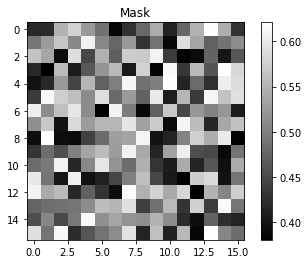

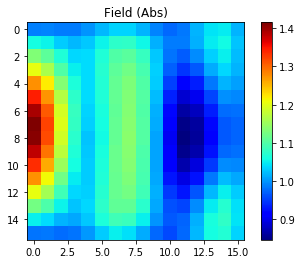

1
2
3
4
5
6
7
8
9
10
11


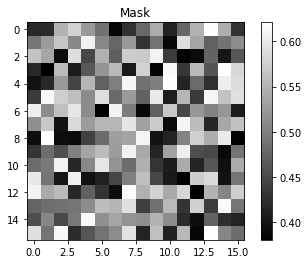

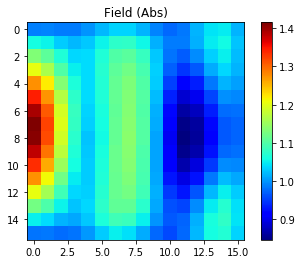

In [73]:
from scipy.optimize import minimize

def plot_solution(y):
    mask = get_primal_mask(y)
    eps = get_eps_from_mask(e,mask).reshape((-1,1))
    field, info = launch_solver(eps, k)
    visualize(mask,"Mask","gray")
    visualize(np.abs(field).reshape(-1,size),"Field (Abs)")

i=0
def get_primal_mask(y,p=1):
    x = (np.tanh(p*y)+1)/2
    return x



def callback(x):
    global i
    i+=1
    print(i)

def penalty(x,p):
    #return np.sum(1-x**p-(1-x)**p)
    return np.sum(x*(1-x))

def objective(y):
    mask = get_primal_mask(y)
    eps = get_eps_from_mask(e,mask).reshape((-1,1))
    field, info = launch_solver(eps, k)
    if info !=0:
        raise RuntimeError()
    obj = -np.max(np.abs(field))#+penalty(mask,20)*0.01
    #print(obj)
    return obj

def get_random_mask(size):
    mask = np.random.rand(size,size)
    return mask

# def search_with_restarts(num):
    
#y = np.random.random(size,size)
# mask =circular_mask(size)
noize = (get_random_mask(size)-0.5)*0.5
# mask = (mask + noize)/np.max(noize+0.001)
#y = circular_mask(size)-0.5+noize
#y = np.ones((size,size))*100
y = noize
mask = get_primal_mask(y)
plot_solution(y)
sol = minimize(objective,y,method = "CG",options={'maxiter': 100, 'gtol':1e-9}, callback = callback)
best_y = sol.x.reshape(-1,size)
plot_solution(best_y)

    

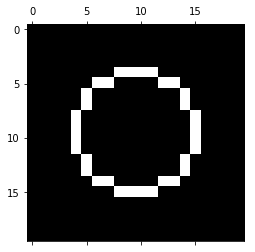

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/cvxpy/expressions/expression.py:289: UserWarning: Forming a nonconvex expression (affine)*(affine).
  warnings.warn("Forming a nonconvex expression (affine)*(affine).")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:228: ComplexWarning: Casting complex values to real discards the imaginary part
  return new.astype(intype)


DCPError: Problem does not follow DCP rules.

In [121]:
import cvxpy as cvx

size = 20
k  = 2*np.pi/(size/7)
F = get_plane_wave(1,k,size)
I = np.eye(size**2)
G = np.random.randint(0,1000,(size**2,size**2))



M = cvx.Bool(size,size)
X = cvx.Variable(size,size)
Y = cvx.Variable(1)

A = I-G@cvx.diag(cvx.vec(M))
y,x = np.mgrid[:size, :size]
x0 = y0 = (size-1)/2
r = size/4

mask_zone = (x-x0)**2+(y-y0)**2<=r**2
no_mask_zone = (x-x0)**2+(y-y0)**2>=(r+1)**2
plt.spy(mask_zone+no_mask_zone)

plt.show()
# lambda val: matvec2(val,eps,k,e
obj = cvx.Maximize(Y)
#A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda val: val)
#print(A.dot([1,1,0,0]))
costrs = [A@cvx.vec(X)==F.reshape(-1,1),Y>=cvx.vec(X),M[mask_zone]==1,M[no_mask_zone]==0]
prob = cvx.Problem(obj,costrs)
prob.solve()
print(prob.value)

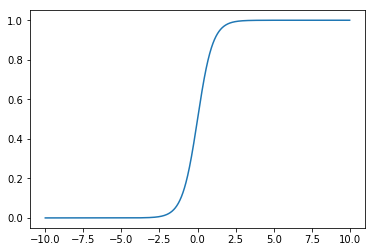

In [68]:
x=y = np.arange(-10,10,0.01)
plt.plot(x,get_primal_mask(y))
plt.show()

In [270]:
i=0

def plot_solution(mask,neighbors=mask):
    eps = get_eps_from_mask(e,mask).reshape((-1,1))
    field, info = launch_solver(eps, k)
    grad = get_grad(mask,neighbors,field)
    visualize(mask,"Mask","gray")
    visualize(np.abs(field).reshape(-1,size),"Field (Abs)","magma")
    visualize(np.abs(field).reshape(-1,size)*(1-mask),"Field (Abs with mask)","magma")
    visualize(grad.reshape(-1,size)*(1-mask)*(1-mask),"Gradiend","jet")
#     neg = plt.imshow(, cmap="jet", interpolation='none')
#     plt.title("Grad")
#     plt.colorbar(neg)
#     plt.show()

def get_primal_mask(y,p=1):
    x = (np.tanh(p*y)+1)/2
    return x


def callback(x):
    global i
    i+=1
    print(i)

def penalty(x,p):
    #return np.sum(1-x**p-(1-x)**p)
    return np.sum(x*(1-x))

def objective(mask,get_field = False):
    mask = mask.reshape(-1,1)
    eps = get_eps_from_mask(e,mask).reshape((-1,1))
    field, info = launch_solver(eps, k)
    if info !=0:
        raise RuntimeError()
    outside_field_inds = np.argwhere(mask==0)
    outside_field =field[outside_field_inds] 
    obj = np.max(np.abs(outside_field))#+penalty(mask,20)*0.01
    #print(obj)
    if get_field:
        return obj, field
    else:
        return obj

def get_random_mask(size):
    mask = np.random.rand(size,size)
    return mask

def get_neigbor_mask(tabu_mask):
    if tabu_mask is None:
        return np.ones((size,size))
    else:
        empty_mask = np.zeros((size,size))
        x_plus_mask = np.zeros((size,size))
        x_plus_mask[:-1,:] = tabu_mask[1:,:]
        x_minus_mask = np.zeros((size,size))
        x_minus_mask[1:,:] = tabu_mask[:-1,:]
        y_plus_mask = np.zeros((size,size))
        y_plus_mask[:,:-1] = tabu_mask[:,1:]
        y_minus_mask = np.zeros((size,size))
        y_minus_mask[:,1:] = tabu_mask[:,:-1]
        extanded_mask = x_plus_mask + x_minus_mask + y_plus_mask +y_minus_mask
        neigbor_mask = (extanded_mask.astype(np.bool)) * (~tabu_mask.astype(np.bool))
        return neigbor_mask

    
def neigbor_gen(tabu_mask,neigbor_mask):
    if tabu_mask is None:
        tabu_mask = np.zeros((size,size))
    neigbor_inds = np.argwhere(neigbor_mask == 1)
    for neigbor_ind in neigbor_inds:
        neigbor_mask = tabu_mask.copy()
        neigbor_mask[tuple(neigbor_ind)]=1
        yield neigbor_mask

def get_best_neigbor(obj_fun,neigbor_gen):
    best_neigbor = None
    best_obj = -np.inf
    for neigbor in neigbor_gen:
        obj = obj_fun(neigbor)
        if obj>= best_obj:
            best_obj = obj
            best_neigbor = neigbor
    return best_obj,best_neigbor


def get_best_mask(obj_fun, mask0 = None):
    tabu_mask = mask0
    i=0
    best_neigbor = None
    best_obj = -np.inf
    while True:
        neigbor_mask = get_neigbor_mask(tabu_mask)
        neigbors = neigbor_gen(tabu_mask,neigbor_mask)
        obj,neigbor = get_best_neigbor(obj_fun,neigbors)
        if obj<best_obj:
            break
        else:
            if i%size==0:
                print(i)
                plot_solution(neigbor)
            i+=1
            tabu_mask = neigbor
            best_obj = obj
            best_neigbor = neigbor
    return best_obj, best_neigbor
            

    


    
def solve():
    best_mask = None
    best_obj = -np.inf 


mask0 = circular_mask(size)
mask0 = empty_mask(size)
mask0[size//2,0]=1


#obj, mask = get_best_mask(objective,mask0)
print("Finish")
#obj, mask = get_best_mask(lambda n: np.sum(np.argwhere(n==1)))


# neigbor_mask = get_neigbor_mask(tabu_mask)
# neigbor_gen = neigbor_gen(tabu_mask,neigbor_mask)
# obj, mask = get_best_neigbor(lambda n: np.sum(np.argwhere(n==1)),neigbor_gen)
mask[0,0] =0 



# for i in neigbor_gen:
#     plt.spy(i)
#     plt.show()
#     print(1)
# print(343)


# def search_with_restarts(num):
    
#y = np.random.random(size,size)
# mask =circular_mask(size)
#noize = (get_random_mask(size)-0.5)*0.5
# mask = (mask + noize)/np.max(noize+0.001)
#y = circular_mask(size)-0.5+noize
#y = np.ones((size,size))*100
# y = noize
# mask = get_primal_mask(y)
# plot_solution(y)
# sol = minimize(objective,y,method = "CG",options={'maxiter': 100, 'gtol':1e-9}, callback = callback)
# best_y = sol.x.reshape(-1,size)
# plot_solution(best_y)



Finish


0


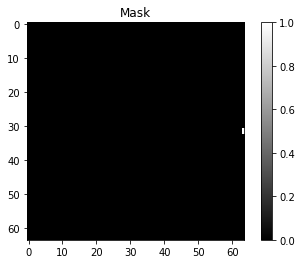

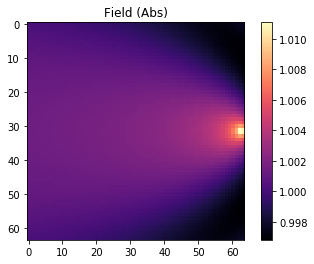

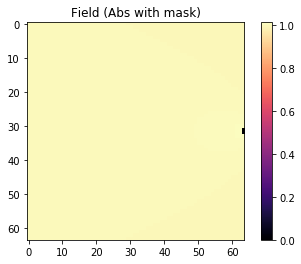

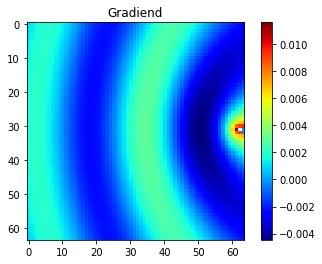

10


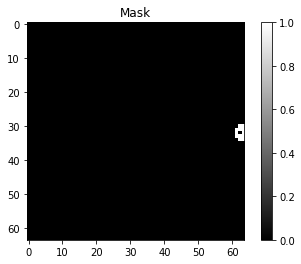

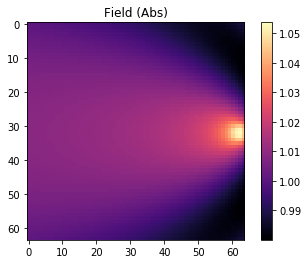

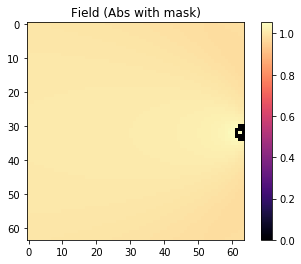

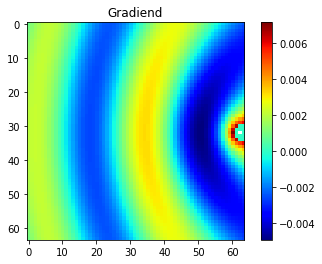

20


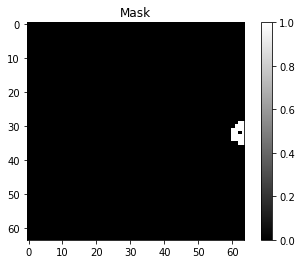

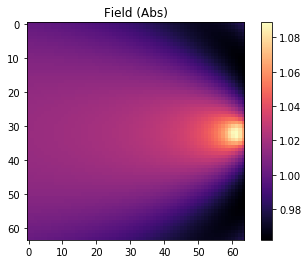

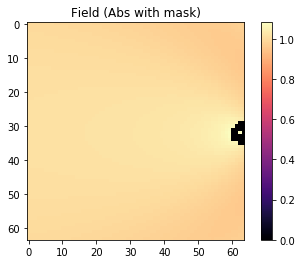

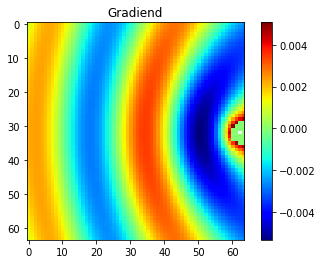

30


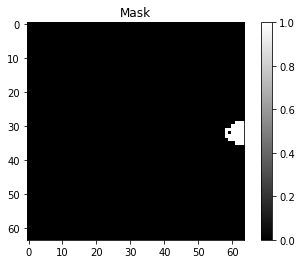

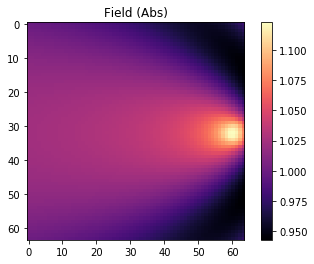

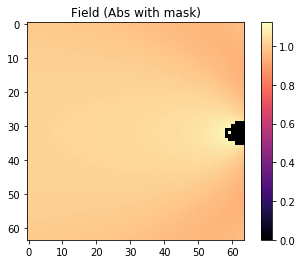

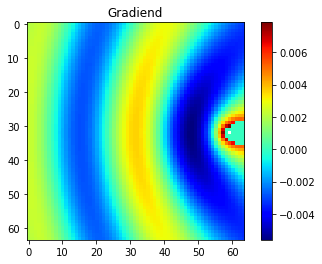

In [ ]:
y_last = np.ones(size**2)

def get_jac_row(num,mask,x):
    global y_last
    y0 = y_last
    eps = get_eps_from_mask(e,mask).reshape((-1,1))
    one_vect = np.zeros(size**2)
    one_vect[num] = 1
    At = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k,True))
    yi = gmres_solver(At,one_vect,y0,100,1e-10,display_convergence_info =False)
    jac = k**2*(e - 1)*x.reshape(-1,1)*G_matvec(yi,k)    
    y_last = yi
    return jac

def get_grad(mask,neighbors,field):
    max_ind = np.argmax(neighbors.reshape(-1,1)*np.abs(field).reshape(-1,1))
    #print(neighbors.reshape(-1,1).shape,np.abs(field).reshape(-1,1).shape)
    jac_row = get_jac_row_2(max_ind,mask,field)
    jac_row[max_ind] = -np.inf
    return 2*(np.conjugate(field[max_ind])*jac_row).real

def get_best_grad_neigbor(obj_fun,mask,neighbors):
    #print(obj_fun)
    obj, field = obj_fun(mask,True)
    grad = get_grad(mask,neighbors,field)
    not_allowd_inds = np.argwhere(neighbors.reshape(-1,1) == 0)
    truncated_grad = grad.copy()
    truncated_grad[not_allowd_inds] = -np.inf
    
#     plt.spy(neighbors)
#     plt.show()
    
#     neg = plt.imshow(grad.reshape(-1,size)*(1-mask), cmap="jet", interpolation='none')
#     if i%10==0:
#         plt.title("Grad")
#         plt.colorbar(neg)
#         plt.show()
    best_ind = np.argmax(truncated_grad)
    best_neighbor = mask.reshape(-1,1).copy()
    best_neighbor[best_ind] = 1
    best_neighbor = best_neighbor.reshape(-1,size)
    best_obj = obj_fun(best_neighbor)
    return best_obj,best_neighbor

def get_best_mask(obj_fun, mask0 = np.zeros((size,size))):
    tabu_mask = mask0
    i=0
    best_neigbor = None
    best_obj = -np.inf
    while True:
        neigbor_mask = get_neigbor_mask(tabu_mask)

        obj,neigbor = get_best_grad_neigbor(obj_fun,tabu_mask,neigbor_mask)
        if obj<best_obj:
            tabu_mask = neigbor
            best_obj = obj
            best_neigbor = neigbor
            break
        else:
            if i%10==0:
                print(i)
                plot_solution(neigbor,neigbor_mask)
            i+=1
            tabu_mask = neigbor
            best_obj = obj
            best_neigbor = neigbor
    return best_obj, best_neigbor

mask0 = empty_mask(size)
mask0[(size-1)//2,size-1]=1
obj,mask = get_best_mask(objective,mask0)
plot_solution(mask)
print("Finish")

# mask = rectangle_mask(size)
# mask[(size-1)//2,size-1]=0
# mask[size-4,size-1]=1
# plt.spy(mask)
# plt.show()
# eps = get_eps_from_mask(e,mask).reshape((-1,1))
# field, info = launch_solver(eps, k)
# grad = get_grad(mask,field).reshape(-1,size)
# neg = plt.imshow(grad, cmap="jet", interpolation='none')
# plt.colorbar(neg)
# plt.show()
# print(np.max(np.abs(field)))

In [204]:
arg_max = np.argmax(np.abs(field))
print(arg_max)
print(np.abs(field)[arg_max])

510
1.74409101274
